In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa

In [2]:
all_data = np.load('processed_data/all_data.npy', allow_pickle=True)[:, 1:, :]
labels = np.load('processed_data/all_labels.npy', allow_pickle=True)
labels = [i-1 for i in labels]
sr = 1000

In [11]:
onset

(array([862, 863, 864, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895,
        896, 909, 910, 911, 912, 913, 914, 915, 916, 917, 918, 940, 941,
        942, 943, 944, 945, 946, 947]),)

In [147]:
def get_rms(data, frame_length, step):
    rms = []
    for i in range(0, len(data)-frame_length+1, step):
        rms.append(np.sqrt(np.mean(data[i:i+frame_length]**2)))
    return np.array(rms).squeeze()

In [146]:
get_rms(all_data[0, 0, :], 200, 100)

0
100
200
300
400
500
600
700
800
900
1000
1100


array([  2102.19747917,   1800.16031251,   1386.5096774 ,   1394.70312987,
         1565.08585399,   1524.26910044,   1507.78693273, 226558.20205436,
       442487.17269333, 380117.31571099,   5353.58155819,   4089.81291939])

In [80]:
def find_onset_index(rms):
    threshold = 0.4
    for i in range(len(rms)):
        if rms[i] > threshold:
            return i
        

In [81]:
def find_onset_time(data, threshold, frame_length, step):
    rms = get_rms(data, frame_length, step)
    index = find_onset_index(rms)
    return index * step

In [102]:
def moving_average(rms):
    w = 1
    return np.convolve(rms, np.ones(w), 'valid') / w

In [121]:
def normalize(rms):
    #min max scaler
    return np.array([n/(max(rms)-min(rms)) for n in rms])

In [140]:
def get_onset(signal, frame_size, step, threshold=0.4):
    rms = get_rms(signal, frame_size, step)
    print(f"initial rms: {rms}")
    rms = moving_average(rms)
    print(f"moving average rms: {rms}")
    rms = normalize(rms)
    print(f"normalized rms: {rms}")
    index = np.where(rms >threshold)[0][0]
    onset = index * step
    return onset


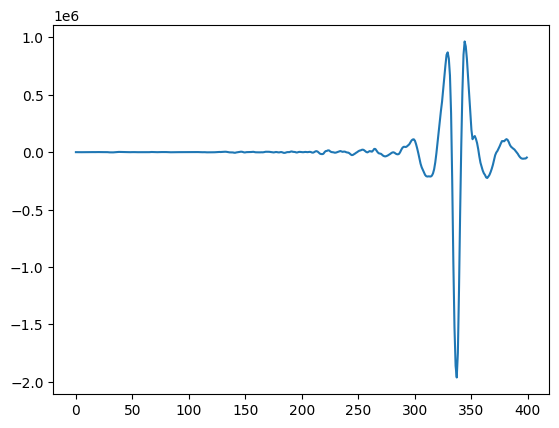

In [142]:
plt.plot(signal[:400])

initial rms: [   877.86401884   1580.49549618   8265.73422959 465371.57709725
 465572.5841005  465504.41487165  14074.11387593   5222.57615448
   5753.26471363   5388.29330147   3541.620715  ]
moving average rms: [   877.86401884   1580.49549618   8265.73422959 465371.57709725
 465572.5841005  465504.41487165  14074.11387593   5222.57615448
   5753.26471363   5388.29330147   3541.620715  ]
normalized rms: [0.00188912 0.00340115 0.01778745 1.00145656 1.00188912 1.00174242
 0.0302868  0.01123872 0.01238074 0.01159534 0.00762139]


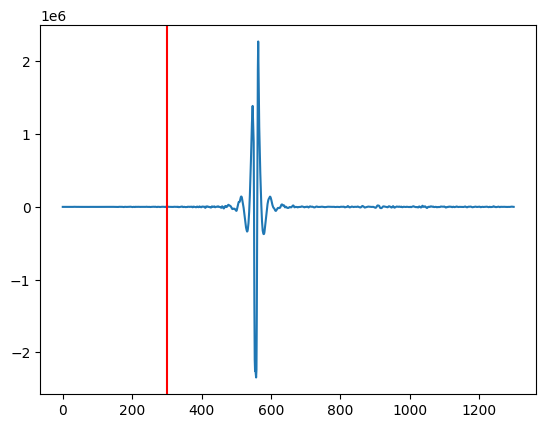

In [160]:
signal = all_data[9, 0, :]
onset = get_onset(signal, 300, 100)
plt.plot(signal)
plt.axvline(x=onset, color='r', linestyle='-')

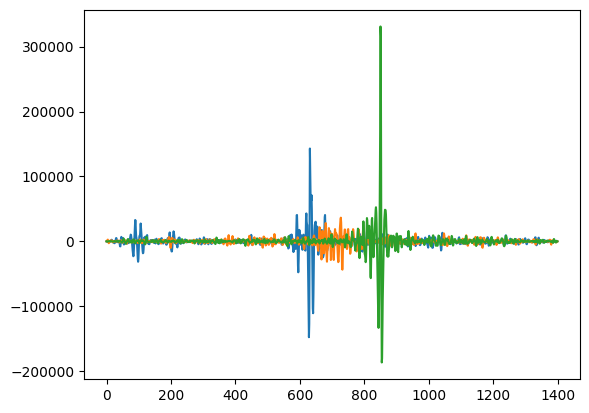

In [19]:
plt.plot(all_data[0][0])
plt.plot(all_data[1][0])
plt.plot(all_data[2][0])